Image classification

https://huggingface.co/docs/transformers/tasks/image_classification


https://discuss.huggingface.co/t/clipmodel-finetuning/13388

https://huggingface.co/blog/fine-tune-clip-rsicd

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import cv2

In [64]:
train = pd.read_csv('../input/agrocode-data-science-cup-2022/train.csv')

In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4876 entries, 0 to 4875
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   idx      4876 non-null   int64 
 1   item_nm  4876 non-null   object
dtypes: int64(1), object(1)
memory usage: 76.3+ KB


In [66]:
train['first_w'] = train['item_nm'].str.split(' ').str[0]
train['first_2w'] = train['item_nm'].str.split(' ').str[0:2].str.join(" ")
train['name_cls'] = train['item_nm'].str.findall('[а-яА-Я]{2,}').str.join(' ')

In [67]:
train.head()

,idx,item_nm,first_w,first_2w,name_cls
0,7062,Кольцо уплотнительное шарикового подшипника,Кольцо,Кольцо уплотнительное,Кольцо уплотнительное шарикового подшипника
1,7203,Корпус подшипника,Корпус,Корпус подшипника,Корпус подшипника
2,35,Кран гидравлический замедлительный М18/М18,Кран,Кран гидравлический,Кран гидравлический замедлительный
3,7023,Труба K-Flex ST 13х22 (2м),Труба,Труба K-Flex,Труба
4,430,Болт M12x30 Kuhn,Болт,Болт M12x30,Болт


In [68]:
len(train['first_w'].value_counts()[train['first_w'].value_counts() > 5])

163

In [69]:
len(train['first_2w'].value_counts()[train['first_2w'].value_counts() > 5])

176

In [70]:
len(train['name_cls'].value_counts()[train['name_cls'].value_counts() > 3])

249

In [71]:
value_counts_dict = dict(train['name_cls'].value_counts())
value_counts_enumerate = {k: i for i, k in enumerate(value_counts_dict)}
train['class'] = train['name_cls'].apply(lambda x: value_counts_enumerate[x]+1 if value_counts_dict[x] > 3 else 0)

In [72]:
train['class'].value_counts()

0      2138
1        94
2        83
3        67
4        64
       ... 
241       4
228       4
224       4
242       4
205       4
Name: class, Length: 250, dtype: int64

In [73]:
train['path'] = train['idx'].apply(lambda x: f'../input/agrocode-data-science-cup-2022/train/train/{x}.png')

In [74]:
train = train.drop(train[train['class'] == 0].index)

In [75]:
train['class'] = train['class'] - 1

In [76]:
import datasets

features = datasets.Features({
    'image': datasets.Image(),
    'label': datasets.Value('int32')
})

dataset_dict = {
    'image': train['path'].values,
    'label': train['class'].values
}

dataset = datasets.Dataset.from_dict(dataset_dict, features)

In [77]:
# # Creating a ClassLabel Object
# df = dataset["train"].to_pandas()
# labels = df['label'].unique().tolist()
# ClassLabels = ClassLabel(num_classes=len(labels), names=labels)

# # Mapping Labels to IDs
# def map_label2id(example):
#     example['label'] = ClassLabels.str2int(example['label'])
#     return example

# dataset = dataset.map(map_label2id, batched=True)

# # Casting label column to ClassLabel Object
# dataset = dataset.cast_column('label', ClassLabels)

In [78]:
dataset = dataset.train_test_split(test_size=0.1)
dataset["train"][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 'label': 151}

In [79]:
# labels = food["train"].features["label"].names
# label2id, id2label = dict(), dict()
# for i, label in enumerate(labels):
#     label2id[label] = str(i)
#     id2label[str(i)] = label

Preprocess

In [80]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224") # google/vit-base-patch16-224-in21k

loading feature extractor configuration file https://huggingface.co/microsoft/beit-base-patch16-224/resolve/main/preprocessor_config.json from cache at /root/.cache/huggingface/transformers/7c6becd6ef1822bce2bd8baca5b4343c69c098364f6bfe289cd6f8bf8d6fb646.878734eb39ada5e348879e41284e2c6a20c7e736d413cf2a1acaa51930c80716
Feature extractor BeitFeatureExtractor {
  "crop_size": 224,
  "do_center_crop": false,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "BeitFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "reduce_labels": false,
  "resample": 2,
  "size": 224
}



In [81]:
feature_extractor

BeitFeatureExtractor {
  "crop_size": 224,
  "do_center_crop": false,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "BeitFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "reduce_labels": false,
  "resample": 2,
  "size": 224
}

In [82]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor # REPLACE to resize

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_transforms = Compose([RandomResizedCrop(feature_extractor.size), ToTensor(), normalize])

def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [83]:
dataset = dataset.with_transform(transforms)

from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

Train

In [84]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    "microsoft/beit-base-patch16-224", # google/vit-base-patch16-224-in21k
    num_labels=len(train['class'].value_counts()),
    ignore_mismatched_sizes=True)

loading configuration file https://huggingface.co/microsoft/beit-base-patch16-224/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/2f9fc1ecf70474e396b8320053ab418d9db145013b6585434f629808f6777055.44b5782e02b035f5130297ffcb14febc8100b0d900519a5cea72f62cc8f0413d
Model config BeitConfig {
  "_name_or_path": "microsoft/beit-base-patch16-224",
  "architectures": [
    "BeitForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "auxiliary_channels": 256,
  "auxiliary_concat_input": false,
  "auxiliary_loss_weight": 0.4,
  "auxiliary_num_convs": 1,
  "drop_path_rate": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    

In [85]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=32, # 16
    evaluation_strategy="steps",
    num_train_epochs=20, # 4
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=feature_extractor,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2464
  Num Epochs = 20
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1540
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss
100,3.554500,3.659490
200,2.121500,2.486027
300,1.558100,2.184759
400,0.930600,2.249913
500,0.964000,2.256483
600,0.812700,2.253785
700,0.727800,2.295152
800,0.547900,2.263168
900,0.655100,2.202381
1000,0.534400,2.182083


***** Running Evaluation *****
  Num examples = 274
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./results/checkpoint-100/preprocessor_config.json
Deleting older checkpoint [results/checkpoint-1400] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 274
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./results/checkpoint-200/preprocessor_config.json
Deleting older checkpoint [results/checkpoint-1500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 274
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-300
Configuration saved in ./results/checkpoint-300/config.json
Model wei

TrainOutput(global_step=1540, training_loss=1.1078378999388063, metrics={'train_runtime': 1254.9945, 'train_samples_per_second': 39.267, 'train_steps_per_second': 1.227, 'total_flos': 3.8256270521204736e+18, 'train_loss': 1.1078378999388063, 'epoch': 20.0})

In [97]:
preds = trainer.predict(dataset['test'])
preds.predictions.shape, preds.label_ids.shape

***** Running Prediction *****
  Num examples = 274
  Batch size = 8


((274, 249), (274,))

In [102]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
accuracy_score(preds.label_ids, np.argmax(preds.predictions, axis=1))

0.5875912408759124

In [103]:
f1_score(preds.label_ids, np.argmax(preds.predictions, axis=1), average='macro')

0.4730459580087095

Testing

In [88]:
!mkdir weights
!mkdir data
!mkdir data/test
!mkdir data/queries

mkdir: cannot create directory ‘weights’: File exists
mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/test’: File exists
mkdir: cannot create directory ‘data/queries’: File exists


In [89]:
model.save_pretrained('./weights/beit-base-patch16-224_fine_tuned')
feature_extractor.save_pretrained('./weights/beit-base-patch16-224_feature_extractor')

Configuration saved in ./weights/beit-base-patch16-224_fine_tuned/config.json
Model weights saved in ./weights/beit-base-patch16-224_fine_tuned/pytorch_model.bin
Feature extractor saved in ./weights/beit-base-patch16-224_feature_extractor/preprocessor_config.json


['./weights/beit-base-patch16-224_feature_extractor/preprocessor_config.json']

In [90]:
train = pd.read_csv('../input/agrocode-data-science-cup-2022/train.csv')
test = train.sample(frac=0.01, random_state=41)
test.to_csv('./data/test.csv', index=False)
queries = train.sample(frac=0.01, random_state=42)
queries = queries[['idx']]
queries.to_csv('./data/queries.csv')

for idx in test['idx'].values:
    shutil.copy(f'../input/agrocode-data-science-cup-2022/train/train/{idx}.png', './data/test')
for idx in queries['idx'].values:
    shutil.copy(f'../input/agrocode-data-science-cup-2022/train/train/{idx}.png', './data/queries')

In [91]:
import numpy as np
import pandas as pd
from glob import glob
from tqdm.auto import tqdm
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import os
from sklearn.neighbors import NearestNeighbors

from PIL import Image


from transformers import BeitFeatureExtractor, BeitModel, BeitConfig
import torch

queries = pd.read_csv('./data/queries.csv')
test = pd.read_csv('./data/test.csv')

configuration = BeitConfig()
# configuration.use_mean_pooling = True

# feature_extractor = BeitFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224-pt22k")
# model = BeitModel.from_pretrained("microsoft/beit-base-patch16-224-pt22k", configuration)


feature_extractor = BeitFeatureExtractor.from_pretrained("./weights/beit-base-patch16-224_feature_extractor")
model = BeitModel.from_pretrained("./weights/beit-base-patch16-224_fine_tuned")

def extract_features(path, model=model):
    img = Image.open(path).convert('RGB')
    img = img.resize((224, 224))

    inputs = feature_extractor(img, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

#     feature = outputs.last_hidden_state[:, -1]
    feature = outputs.pooler_output
    
    feature = torch.squeeze(feature).numpy()

    return feature / np.linalg.norm(feature)


test_embeddings = []

for idx in tqdm(test.idx):
    test_embeddings.append(extract_features(f'./data/test/{idx}.png'))

test_embeddings = np.array(test_embeddings)

queries_embeddings = []

for idx in tqdm(queries.idx):
    queries_embeddings.append(extract_features(f'./data/queries/{idx}.png'))
    
queries_embeddings = np.array(queries_embeddings)

neigh = NearestNeighbors(n_neighbors=10, metric='cosine')
neigh.fit(test_embeddings)

distances, idxs = neigh.kneighbors(queries_embeddings, 10, return_distance=True)

pred_data = pd.DataFrame()
distances = 1 - distances
pred_data['score'] = distances.flatten()

pred_data['database_idx'] = [test.idx.iloc[x] for x in idxs.flatten()]
pred_data.loc[:, 'query_idx'] = np.repeat(queries.idx, 10).values

pred_data.to_csv('./data/submission.csv', index=False)

loading feature extractor configuration file ./weights/beit-base-patch16-224_feature_extractor/preprocessor_config.json
Feature extractor BeitFeatureExtractor {
  "crop_size": 224,
  "do_center_crop": false,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "BeitFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "reduce_labels": false,
  "resample": 2,
  "size": 224
}

loading configuration file ./weights/beit-base-patch16-224_fine_tuned/config.json
Model config BeitConfig {
  "_name_or_path": "microsoft/beit-base-patch16-224",
  "architectures": [
    "BeitForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "auxiliary_channels": 256,
  "auxiliary_concat_input": false,
  "auxiliary_loss_weight": 0.4,
  "auxiliary_num_convs": 1,
  "drop_path_rate": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

In [92]:
pred_data.groupby(['query_idx']).agg({'score': np.max, 'database_idx': 'first'}).sort_values(by='score', ascending=False)

,score,database_idx
query_idx,,
6296,1.000000,4588
5255,0.761832,1234
4494,0.754437,1251
6079,0.716221,225
894,0.701395,7237
4865,0.678732,651
3932,0.678137,4286
2585,0.627012,4286
6546,0.625182,1251


In [93]:
idx_f = 6079
pred_data[pred_data.query_idx == idx_f]

,score,database_idx,query_idx
360,0.716221,225,6079
361,0.275823,6118,6079
362,0.260696,2821,6079
363,0.259556,5859,6079
364,0.214252,5070,6079
365,0.188278,4155,6079
366,0.176936,651,6079
367,0.173082,1708,6079
368,0.168034,6073,6079
369,0.165163,3075,6079


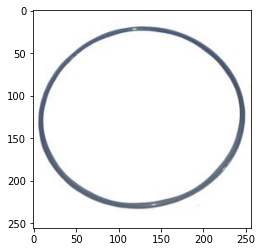

candidates:
score: [0.71622145]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


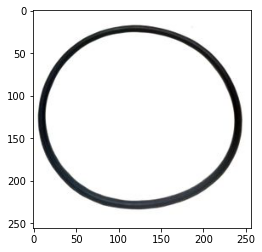

score: [0.27582276]


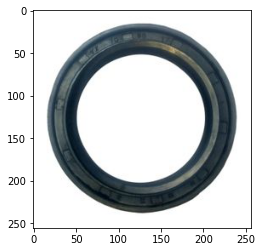

score: [0.26069564]


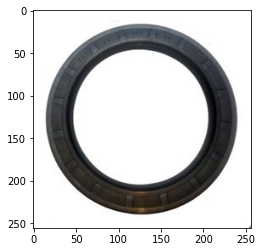

score: [0.25955558]


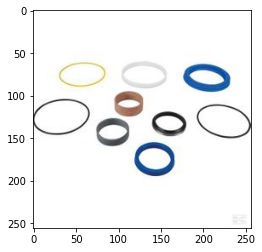

score: [0.21425247]


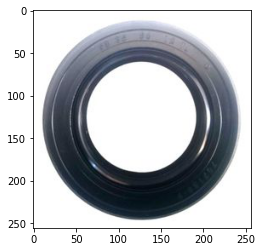

score: [0.1882782]


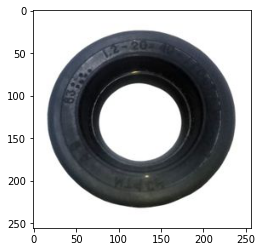

score: [0.17693633]


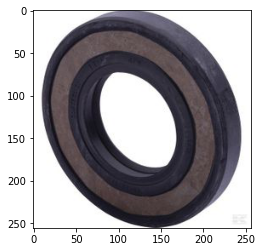

score: [0.17308235]


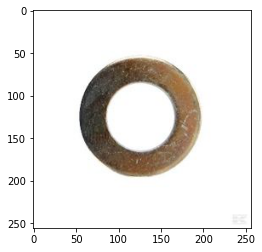

score: [0.16803402]


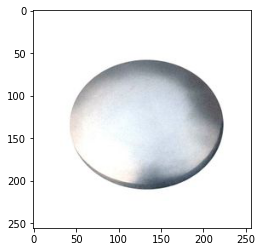

score: [0.16516328]


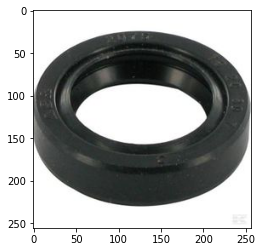

In [94]:
import cv2
import matplotlib.pyplot as plt

img_path = f'../input/agrocode-data-science-cup-2022/train/train/{idx_f}.png'
img1 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()
print('candidates:')

idx_s = pred_data[pred_data.query_idx == idx_f]['database_idx'].values

for i in idx_s:
    img_path = f'../input/agrocode-data-science-cup-2022/train/train/{i}.png'
    img2 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    print(f'score: {pred_data[pred_data.query_idx == idx_f][pred_data["database_idx"] == i]["score"].values}')
    plt.imshow(img2)
    plt.show()

https://huggingface.co/blog/fine-tune-vit

https://github.com/huggingface/notebooks/blob/main/examples/image_classification.ipynb

https://huggingface.co/docs/datasets/image_process

https://medium.com/@kenjiteezhen/image-classification-using-huggingface-vit-261888bfa19f

In [95]:
# import numpy as np
# from datasets import Features, ClassLabel, Array3D

# def preprocess_images(examples):
#   images = examples['img']  
#   images = [np.array(image, dtype=np.uint8) for image in images] 
#   images = [np.moveaxis(image, source=-1, destination=0) for image in images] 
#   inputs = feature_extractor(images=images) 
#   examples['pixel_values'] = inputs['pixel_values'] 

#   return examples 

# features = Features({
#     'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']),
#     'img': Image(decode=True, id=None),
#     'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)), })

# preprocessed_train_ds = train_ds.map(preprocess_images, batched=True, features=features) 
# preprocessed_val_ds = val_ds.map(preprocess_images, batched=True, features=features) 
# preprocessed_test_ds = test_ds.map(preprocess_images, batched=True, features=features)

In [96]:
!zip -r ./model.zip ./weights/beit-base-patch16-224_fine_tuned
!zip -r ./fe.zip ./weights/beit-base-patch16-224_feature_extractor

updating: weights/beit-base-patch16-224_fine_tuned/ (stored 0%)
updating: weights/beit-base-patch16-224_fine_tuned/pytorch_model.bin (deflated 8%)
updating: weights/beit-base-patch16-224_fine_tuned/config.json (deflated 76%)
updating: weights/beit-base-patch16-224_feature_extractor/ (stored 0%)
updating: weights/beit-base-patch16-224_feature_extractor/preprocessor_config.json (deflated 48%)
